In [2]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import os
import math
from tqdm import tqdm
from tqdm import trange
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random


In [3]:
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, path_dir, map_file, transform=None, shape = (100,100), device='cpu'):
        self.device = device
        self.paths = [] # create a list to hold all paths read from file
        # self.map = np.loadtxt(map_file, skiprows=2).reshape(shape)
        # self.map = self.map[np.newaxis, :, :]
        x = torch.tensor([]) # empty list to hold input series tensors
        num_paths = 0
        for filename in tqdm(os.listdir(path_dir)):
            num_paths += 1
            with open(os.path.join(path_dir, filename), 'r') as f: # open in readonly mode
                path_points_list = [] # a list to hold each point in a path
                self.flat_path = np.loadtxt(f) # load in the flat path from file
                self.path = np.asarray(self.flat_path, dtype=np.float32).reshape(len(self.flat_path)//2,2) #unflatten the path from the file
                # print(self.path)
                for point in self.path:
                    x = point[0]
                    y = point[1]
                    this_point = [x, y]
                    path_points_list.append(this_point)
            sequence = torch.tensor(path_points_list, dtype=torch.float)[:, :]
            self.paths.append(sequence)
                # self.path_tensor = self.convert_path(shape, self.path)

        # self.sequences = []
        # for path in range(len(path_list)):
        #    self.sequences.append((path_list[path] - mu)/sig)
        
        self.transform = transform
        print("Done!")

    def convert_path(self, map_dim, path):
        path_mat = np.zeros(map_dim, dtype=float)

        # Make the path continuous
        for i in range(path.shape[0] - 1):
            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            if (x1 < x2):
                x_dir = 1
            else:
                x_dir = -1

            if (y1 < y2):
                y_dir = 1
            else:
                y_dir = -1

            # Determine y from x
            if x2-x1 != 0:
                m = (y2-y1)/(x2-x1)
                while x != x2:
                    y = round(m*(x-x1) + y1)
                    path_mat[y,x] = 1
                    x += x_dir
            else:
                while x != x2:
                    path_mat[y1,x] = 1
                    x += x_dir


            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            # Determine x from y
            if y2-y1 != 0:
                m = (x2-x1)/(y2-y1)
                while y != y2:
                    x = round(m*(y-y1) + x1)
                    path_mat[y,x] = 1
                    y += y_dir
            else:
                while y != y2:
                    path_mat[y,x1] = 1
                    y += y_dir

        # print(path)
        # print(f'xs: {path[:,0]}')
        # print(f'ys: {path[:,1]}')
        # path_tensor = torch.tensor(path)
        # print(path_tensor)
        return path

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # x = np.float32(self.sequences[idx])
        # x = torch.Tensor(x).to(self.device)

        x = self.paths[idx]
        if self.transform:
            x = self.transform(x)
        
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dataset name
MAP_NAME = '8x12_map_cropped'
DATASET = 'random_paths'
MAP_SHAPE = (64,64)
# training parameters
BATCH_SIZE = 1
train_dataset = PathsDataset(path_dir = f"./env/{MAP_NAME}/paths/{DATASET}/dense", map_file = f"./env/{MAP_NAME}/{MAP_NAME}.txt", shape = MAP_SHAPE, transform=None, device=device)
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 59687/59687 [00:18<00:00, 3241.50it/s]

Done!


In [5]:
train_target_paths = []
train_input_paths = []

test_target_paths = []
test_input_paths = []

nbr_eval_paths = 10

for path in train_dataset[nbr_eval_paths:]:
    input_path = path[:-1] #all points execpt last
    target_path = path[1:]

    train_target_paths.append(target_path)
    train_input_paths.append(input_path)

for path in train_dataset[:nbr_eval_paths]:
    input_path = path[:-1] #all points execpt last five
    target_path = path[1:]

    test_target_paths.append(target_path)
    test_input_paths.append(input_path)


print(len(train_input_paths))
print(len(test_input_paths))
train_input_paths[3]

59677
10


tensor([[42.0000, 53.0000],
        [42.6000, 52.2000],
        [43.2000, 51.4000],
        [43.8000, 50.6000],
        [44.4000, 49.8000],
        [45.0000, 49.0000],
        [45.7500, 48.5000],
        [46.5000, 48.0000],
        [47.2500, 47.5000],
        [48.0000, 47.0000],
        [48.7500, 46.2500],
        [49.5000, 45.5000],
        [50.2500, 44.7500],
        [51.0000, 44.0000],
        [51.7500, 43.2500],
        [52.5000, 42.5000],
        [53.2500, 41.7500],
        [54.0000, 41.0000],
        [54.7500, 40.5000],
        [55.5000, 40.0000],
        [56.2500, 39.5000],
        [57.0000, 39.0000],
        [56.0000, 38.5000],
        [55.0000, 38.0000],
        [54.0000, 37.5000],
        [53.0000, 37.0000],
        [53.0000, 36.0000],
        [53.0000, 35.0000],
        [53.0000, 34.0000],
        [53.0000, 33.0000],
        [52.0000, 32.5000],
        [51.0000, 32.0000],
        [50.0000, 31.5000],
        [49.0000, 31.0000],
        [48.2500, 30.2500],
        [47.5000, 29

In [6]:
class MyLSTM(nn.Module):
  def __init__(self, in_d=2, out_d=2, hidden_d=120):
    self.hidden_d = hidden_d
    super(MyLSTM, self).__init__()
    self.lstm1 = nn.LSTMCell(input_size=in_d, hidden_size=hidden_d)
    self.lstm2 = nn.LSTMCell(input_size=hidden_d, hidden_size=hidden_d)
    self.fc = nn.Linear(hidden_d, out_d)

    # Initialize embedding layer
    # self.embedding = nn.Embedding(in_d, out_d, padding_idx=0)


  def forward(self, x, future=0):
    # print(x)
    self.sequence_len = len(x)
    outputs = []

    # Creation of cell state and hidden state for layer 1 and 2
    hidden_state_1 = torch.zeros(1, self.hidden_d)
    cell_state_1 = torch.zeros(1, self.hidden_d)
    hidden_state_2 = torch.zeros(1, self.hidden_d)
    cell_state_2 = torch.zeros(1, self.hidden_d)

    

    # initialize weights to random[-0.1, 0.1) (need to update initialzation to match paper)
    # weights initialization
    torch.nn.init.xavier_normal_(hidden_state_1)
    torch.nn.init.xavier_normal_(cell_state_1)
    torch.nn.init.xavier_normal_(hidden_state_2)
    torch.nn.init.xavier_normal_(cell_state_2)

    # From idx to embedding
    # out = self.embedding(x)
    
    # Prepare the shape for LSTMCell
    # out = out.view(self.sequence_len, x.size(0), -1)
    
    # Unfolding LSTM
    # Last hidden_state will be used to feed the fully connected neural net
    # print(f'x: {x}')
    for i in range(len(x)):
      # print(f'x shape: {x.shape}')
      # print(f'x[i]: {x[i]}')
      # print(f'x[i] shape: {x[i:i+1].shape}')
      hidden_state_1, cell_state_1 = self.lstm1(x[i:i+1], (hidden_state_1, cell_state_1))
      hidden_state_2, cell_state_2 = self.lstm2(hidden_state_1, (hidden_state_2, cell_state_2))
      
    # Last hidden state is passed through a fully connected neural net
      output = self.fc(hidden_state_2)	
      # print(f'out: {output}')
      outputs.append(output)

    for i  in range(future): # if we are trying to predict future values (if future is not zero)
      hidden_state_1, cell_state_1 = self.lstm1(x[i:i+1], (hidden_state_1, cell_state_1))
      hidden_state_2, cell_state_2 = self.lstm2(hidden_state_1, (hidden_state_2, cell_state_2))
      
    # Last hidden state is passed through a fully connected neural net
      output = self.fc(hidden_state_2)	
      # print(f'out: {output}')
      outputs.append(output)

    outputs = torch.cat(outputs, dim=0)
    
    return outputs

epoch: 0
1892.7669677734375
122.09969329833984
144.22256469726562
237.04835510253906
160.43821716308594
35.5321044921875
54.47950744628906
46.63270950317383
84.12934112548828
44.84235382080078
26.524169921875
37.812435150146484
17.576644897460938
4.6057844161987305
5.358166694641113
12.304062843322754
7.349552631378174
6.075504302978516
1.3748254776000977
1.1192172765731812
18.538599014282227
3.0557823181152344
3.2031750679016113
2.125291109085083
1.6178598403930664
3.9032254219055176
0.8127526640892029
4.890617847442627
2.075686454772949
0.7183420062065125
2.0387039184570312
7.3700056076049805
1.8079352378845215
10.693425178527832
9.138161659240723
1.7559927701950073
0.5980861783027649
1.9221596717834473
9.929713249206543
3.1344213485717773
2.8314623832702637
7.117012023925781
0.8911035060882568
0.7319121360778809
1.3083610534667969
1.2693376541137695
5.692516803741455
1.0608205795288086
1.768471121788025
1.2670680284500122
0.26343411207199097
2.3573951721191406
1.3579140901565552
1.2

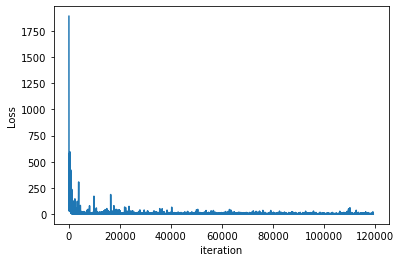

In [7]:
rnn = MyLSTM()
loss = []
criterion = nn.MSELoss()
opt = torch.optim.Adam(rnn.parameters(), lr=0.005)
# n_epochs = 1000
n_epochs = 2
for e in range(n_epochs):
  print(f'epoch: {e}')
  for s in range(len(train_input_paths)):
    # print(train_input_paths[s].shape)
    pred = rnn(train_input_paths[s])  # predict next step, init hidden state to zero at the begining of the sequence
    # print(f'pred: {pred.shape}')
    # print(f'target: {train_target_paths[s].shape}')
    err = criterion(pred, train_target_paths[s])  # predict next step for each step
    opt.zero_grad()
    err.backward()
    opt.step()
    loss.append(err.item())
    if s % 100 is 0:  
      print(err.item())
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

In [8]:
flat_map = np.loadtxt("./env/8x12_map_cropped/8x12_map_cropped.txt", skiprows=2)
map = np.asarray(flat_map).reshape(64,64)

In [9]:
# prediction loop
i = 3 # what path # from the eval dataset we want to look at
with torch.no_grad():
    future=15
    length = train_input_paths[i].shape[0]
    pred = rnn(train_input_paths[i], future=future)
    truth = train_target_paths[i]
    # loss = loss_func(pred[:, :-future], test_target)
    # print(f'loss: {loss.item()}')
    y = pred.detach().numpy()
print(length)
print(y.shape)

51
(66, 2)


In [10]:
# print(train_input_paths[3])
# print(start_point)

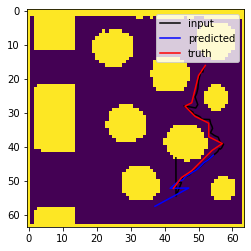

In [11]:
xs = y[:,0]
ys = y[:,1]

plt.imshow(map)
plt.plot(xs[:length], ys[:length], color='k', label = "input")
plt.plot(xs[length:], ys[length:], color='b', label = "predicted")
plt.plot(truth[:,0], truth[:,1], color='r', label = "truth")
plt.legend()

In [12]:
start_points_list = []
coords_list = []

num_points = 150 # num points to predict for each path
paths_to_gen = 6 # num paths to generate

for x in range(paths_to_gen):
    x = random.randint(0, 64)
    y = random.randint(0, 64)
    start_point = torch.from_numpy(np.asarray([[x,y]])).float()
    points = []
    with torch.no_grad():
        pred = rnn(start_point, future=0) # predict the first point based on the start point
        points.append(pred) # append this first predicted point to list
        for point in range(num_points): # now, for the desired number of points predict the next point...
            pred = rnn(pred, future=0)
            points.append(pred)
        points = torch.cat(points, dim=0)

    coords_list.append(points)

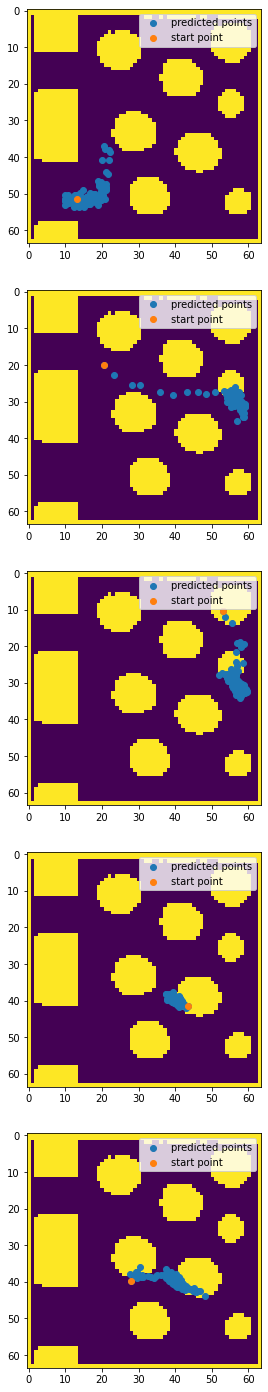

<Figure size 432x288 with 0 Axes>

In [13]:



flat_map = np.loadtxt("./env/8x12_map_cropped/8x12_map_cropped.txt", skiprows=2)
map = np.asarray(flat_map).reshape(64,64)


fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(25, 25))
for x in range(5):
    ax[x].scatter(coords_list[x][:,0], coords_list[x][:,1], label='predicted points')
    ax[x].scatter(coords_list[x][0,0], coords_list[x][0,1], label='start point')
    ax[x].legend()
    ax[x].imshow(map)
plt.show()
plt.tight_layout()